In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
df=pd.read_excel('files_second_analytics/Bariatric Project Study Data 2025_mod.xlsx', sheet_name='Sheet1')

In [23]:
core_X_data=df[['gender', 'age', 'height', 'weight', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt','procedure_category','antibiotics','cholecystectomy_repair','hiatus_hernia_repair']].copy()
cm_cols= [col for col in df.columns if col.startswith('CM_')]

cm_data = df[cm_cols].fillna(0).astype(int)
cm_data
zero_only = [col for col in cm_data.columns if (cm_data[col] == 0).all()]
cm_data = cm_data.drop(columns=zero_only)

# finally, join the filtered CM_ data back into your core set
core_X_data = core_X_data.join(cm_data)
core_X_data.fillna(0, inplace=True)
print(core_X_data.isna().sum())  # should all be zero   

# inspect result
print("Dropped CM columns:", zero_only)
print("Remaining columns in CM data:", cm_data.columns.tolist())
# 1) Grab all the antibiotic dummy columns
ab_cols = [c for c in core_X_data.columns if c.startswith('antibiotics')]

# 2) Count zeros in each column
for col in ab_cols:
    n_zeros = (core_X_data[col] == 0).sum()
    print(f"{col}: {n_zeros} zeros out of {len(core_X_data)} rows")

# 3) (Bonus) How many rows have *no* antibiotic flagged?
no_ab_rows = (core_X_data[ab_cols].sum(axis=1) == 0).sum()
print(f"\nRows where ALL antibiotic dummies are 0 (i.e. original 0): {no_ab_rows}")



gender                    0
age                       0
height                    0
weight                    0
bmi                       0
family_hist_cnt           0
chronic_meds_cnt          0
procedure_category        0
antibiotics               0
cholecystectomy_repair    0
hiatus_hernia_repair      0
CM_AIDS                   0
CM_ANEMDEF                0
CM_ARTH                   0
CM_CHF                    0
CM_DEPRESS                0
CM_DM                     0
CM_DMCX                   0
CM_HTN_C                  0
CM_HYPOTHY                0
CM_LIVER                  0
CM_OBESE                  0
CM_PSYCH                  0
CM_SMOKE                  0
CM_APNEA                  0
CM_CHOLSTRL               0
CM_OSTARTH                0
CM_HPLD                   0
dtype: int64
Dropped CM columns: ['CM_ALCOHOL', 'CM_BLDLOSS', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DRUG', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_PARA', 'CM_PERIVASC', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'C

In [3]:
# Check whether CM_NEURO survived the filtering
if 'CM_CHF' in core_X_data.columns:
    print("CM_CHF is present in core_X_data!")
else:
    
    print("CM_CHFis NOT in core_X_data.")
if 'CM_DRUG' in core_X_data.columns:
    print("CM_NEURO is present in core_X_data!")
else:
    print("CM_NEURO is NOT in core_X_data.")


CM_CHF is present in core_X_data!
CM_NEURO is NOT in core_X_data.


In [4]:
# Identify all complication-related columns
comp_cols = [col for col in df.columns if 'comp' in col.lower()]

# Create new dataset without the original complication columns
df_new = df.drop(columns=comp_cols)

# Add a single 'complication' column: 1 if any original comp column == 1, else 0
df_new['complication'] = (df[comp_cols] == 1).any(axis=1).astype(int)

# Display new dataset shape
print("New dataset shape (rows, columns):", df_new.shape)

# Show a sample of the new 'complication' column alongside the ID
# Show the first 10 rows of id and complication
print(df_new[['id', 'complication']].head(10))
print("First 15 column names:", df_new.columns.tolist())

New dataset shape (rows, columns): (344, 111)
        id  complication
0  45488.0             0
1      NaN             0
2  37462.0             1
3  40661.0             0
4      NaN             0
5  40699.0             0
6  38920.0             0
7  37827.0             0
8  47189.0             0
9      NaN             0
First 15 column names: ['doctor', 'procedure_category', 'hospitalDesc', 'hospital_wardDesc', 'days_since_admission', 'length_of_stay', 'gender', 'age', 'weight', 'height', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt', 'cm_count', 'morbidity', 'CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_SMOKE', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS', 'CM_APNEA', 'CM_CHOLSTRL', 'CM_OSTARTH', 'CM_HPLD', 'emergency_

In [5]:
# Missing values analysis
missing_df = pd.DataFrame({
    'Missing_Count': core_X_data.isnull().sum(),
    'Missing_Percentage': (core_X_data.isnull().sum() / len(core_X_data)) * 100
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print("="*50)
print("MISSING VALUES ANALYSIS")
print("="*50)
print(f"Columns with missing values: {len(missing_df)}/{core_X_data.shape[1]}")
print(f"Total completeness: {(1 - core_X_data.isnull().sum().sum()/(core_X_data.shape[0]*core_X_data.shape[1]))*100:.1f}%")

if len(missing_df) > 0:
    print("\nTop missing columns:")
    print(missing_df.head(10))
    
    # Visualization
    plt.figure(figsize=(10, 6))
    top_missing = missing_df.head(15)
    plt.barh(range(len(top_missing)), top_missing['Missing_Percentage'], color='coral')
    plt.yticks(range(len(top_missing)), top_missing.index)
    plt.xlabel('Missing Percentage (%)')
    plt.title('Top 15 Columns with Missing Values', fontsize=14, fontweight='bold')
    
    for i, v in enumerate(top_missing['Missing_Percentage']):
        plt.text(v + 0.1, i, f'{v:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found!")

MISSING VALUES ANALYSIS
Columns with missing values: 0/28
Total completeness: 100.0%
No missing values found!


In [6]:
core_Y_data=df_new[["complication"]]

core_Y_data.head()

,complication
0,0
1,0
2,1
3,0
4,0


In [7]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
X = core_X_data.copy()
y = core_Y_data['complication'].values

# Handle categorical variables first
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print("Class distribution in training set:")
print(f"No complications: {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"Complications: {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")
print(f"\nClass distribution in test set:")
print(f"No complications: {(y_test==0).sum()} ({(y_test==0).sum()/len(y_test)*100:.1f}%)")
print(f"Complications: {(y_test==1).sum()} ({(y_test==1).sum()/len(y_test)*100:.1f}%)")
X_encoded.head()

Class distribution in training set:
No complications: 248 (90.2%)
Complications: 27 (9.8%)

Class distribution in test set:
No complications: 62 (89.9%)
Complications: 7 (10.1%)


,age,height,weight,bmi,family_hist_cnt,chronic_meds_cnt,cholecystectomy_repair,hiatus_hernia_repair,CM_AIDS,CM_ANEMDEF,...,procedure_category_BPD -DS,procedure_category_Mini gastric bypass (OAGB),procedure_category_RYGBP,procedure_category_SADI,procedure_category_Sleeve,antibiotics_Augmentin,antibiotics_Clindamycin,antibiotics_Invanz,antibiotics_Kefsol,antibiotics_Rocephin
0,50,154,146.0,61.56,0,0,0.0,0.0,0,0,...,False,False,False,True,False,False,False,False,True,False
1,52,168,96.0,34.00,0,0,1.0,0.0,0,0,...,False,False,False,False,True,False,False,False,True,False
2,23,163,143.0,53.82,0,0,0.0,1.0,0,0,...,False,False,False,True,False,False,False,False,True,False
3,23,176,120.0,38.74,0,0,0.0,1.0,0,0,...,False,False,False,False,True,False,False,False,True,False
4,57,162,112.0,42.68,0,7,0.0,1.0,0,0,...,False,False,False,True,False,False,False,False,True,False


In [8]:
# Create baseline model
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Train and evaluate
baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_test)
y_pred_proba_baseline = baseline_pipeline.predict_proba(X_test)[:, 1]

print("BASELINE MODEL (No imbalance handling):")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_baseline):.3f}")

# Confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print(f"\nConfusion Matrix:")
print(f"TN: {cm_baseline[0,0]}, FP: {cm_baseline[0,1]}")
print(f"FN: {cm_baseline[1,0]}, TP: {cm_baseline[1,1]}")
print(f"Sensitivity (Recall): {cm_baseline[1,1]/(cm_baseline[1,0]+cm_baseline[1,1]):.1%}")
print(f"Specificity: {cm_baseline[0,0]/(cm_baseline[0,0]+cm_baseline[0,1]):.1%}")

BASELINE MODEL (No imbalance handling):

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        62
           1       0.00      0.00      0.00         7

    accuracy                           0.88        69
   macro avg       0.45      0.49      0.47        69
weighted avg       0.81      0.88      0.84        69

ROC-AUC Score: 0.774

Confusion Matrix:
TN: 61, FP: 1
FN: 7, TP: 0
Sensitivity (Recall): 0.0%
Specificity: 98.4%


In [9]:
# Alternative: Using class weights instead of resampling
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class weights approach:")
print(f"Class 0 weight: {class_weights[0]:.2f}")
print(f"Class 1 weight: {class_weights[1]:.2f}")

# Train model with class weights
weighted_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

weighted_model.fit(X_train, y_train)
y_pred_weighted = weighted_model.predict(X_test)
y_pred_proba_weighted = weighted_model.predict_proba(X_test)[:, 1]

print("\nClass Weights Model Performance:")
print(classification_report(y_test, y_pred_weighted))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_weighted):.3f}")

Class weights approach:
Class 0 weight: 0.55
Class 1 weight: 5.09

Class Weights Model Performance:
              precision    recall  f1-score   support

           0       0.97      0.61      0.75        62
           1       0.20      0.86      0.32         7

    accuracy                           0.64        69
   macro avg       0.59      0.74      0.54        69
weighted avg       0.90      0.64      0.71        69

ROC-AUC: 0.781


Default threshold: 0.5
Optimal threshold: 0.772
F1 at optimal: 0.462


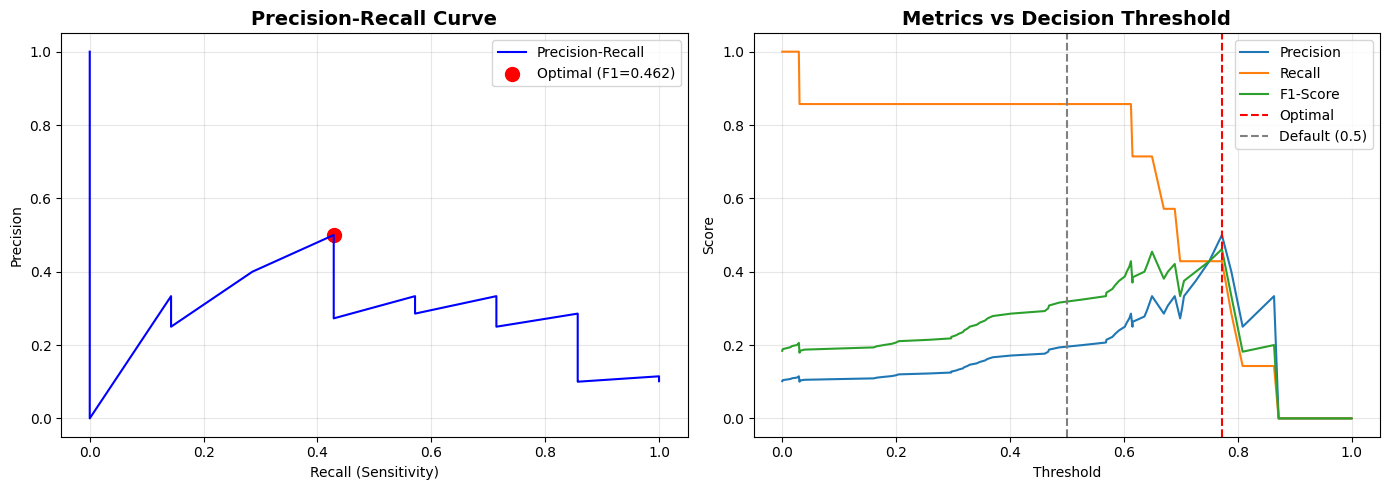


Performance with optimal threshold:
              precision    recall  f1-score   support

           0       0.98      0.76      0.85        62
           1       0.29      0.86      0.43         7

    accuracy                           0.77        69
   macro avg       0.63      0.81      0.64        69
weighted avg       0.91      0.77      0.81        69



In [10]:
from sklearn.metrics import precision_recall_curve

# Get probabilities for class weights model
y_proba = weighted_model.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find optimal threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Default threshold: 0.5")
print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"F1 at optimal: {f1_scores[optimal_idx]:.3f}")

# Plot threshold analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Precision-Recall curve
ax1.plot(recall, precision, 'b-', label='Precision-Recall')
ax1.scatter(recall[optimal_idx], precision[optimal_idx], 
           color='red', s=100, label=f'Optimal (F1={f1_scores[optimal_idx]:.3f})')
ax1.set_xlabel('Recall (Sensitivity)')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Threshold vs Metrics
ax2.plot(thresholds, precision[:-1], label='Precision')
ax2.plot(thresholds, recall[:-1], label='Recall')
ax2.plot(thresholds, f1_scores[:-1], label='F1-Score')
ax2.axvline(x=optimal_threshold, color='red', linestyle='--', label='Optimal')
ax2.axvline(x=0.5, color='gray', linestyle='--', label='Default (0.5)')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Metrics vs Decision Threshold', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test with optimal threshold
y_pred_optimal = (y_proba >= 0.61).astype(int)
print("\nPerformance with optimal threshold:")
print(classification_report(y_test, y_pred_optimal))

In [11]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

# 1) Compute “balanced” weights (or tweak them by hand)
balanced_ws = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
# balanced_ws might look like [0.53, 4.47]

# Option A: use these as-is
#weight_dict = {0: balanced_ws[0], 1: balanced_ws[1]}

# Option B: up‐weight the minority even more, e.g. ×2
weight_dict = {0: balanced_ws[0], 1: balanced_ws[1] * 2}

print("Using class weights:", weight_dict)

# 2) Build & fit the RF pipeline
#    (RF doesn’t actually need scaling, but we include it for parity)
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        class_weight=weight_dict,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipe.fit(X_train, y_train)

# 3) Get predicted probabilities
y_proba_rf = rf_pipe.predict_proba(X_test)[:, 1]

# 4) Find the threshold that maximizes F1 on the test set
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)

# align lengths: thresholds is len(precision)-1
best_idx = np.argmax(f1_scores[:-1])
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\nDefault threshold: 0.5")
print(f"Optimal threshold: {best_thresh:.3f} → F1 = {best_f1:.3f}")

# 5) Evaluate at default vs. optimal
for thresh in [0.5, best_thresh]:
    y_pred = (y_proba_rf >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"\n––– Threshold = {thresh:.2f} –––")
    print(f"TP={tp}, FN={fn}, FP={fp}, TN={tn}")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC (unchanged): {roc_auc_score(y_test, y_proba_rf):.3f}")


Using class weights: {0: 0.5544354838709677, 1: 10.185185185185185}

Default threshold: 0.5
Optimal threshold: 0.185 → F1 = 0.421

––– Threshold = 0.50 –––
TP=0, FN=7, FP=0, TN=62
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        62
           1       0.00      0.00      0.00         7

    accuracy                           0.90        69
   macro avg       0.45      0.50      0.47        69
weighted avg       0.81      0.90      0.85        69

ROC-AUC (unchanged): 0.805

––– Threshold = 0.18 –––
TP=4, FN=3, FP=8, TN=54
              precision    recall  f1-score   support

           0       0.95      0.87      0.91        62
           1       0.33      0.57      0.42         7

    accuracy                           0.84        69
   macro avg       0.64      0.72      0.66        69
weighted avg       0.89      0.84      0.86        69

ROC-AUC (unchanged): 0.805


In [12]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# XGBoost with tuned parameters for small, imbalanced data
xgb_model = XGBClassifier(
    scale_pos_weight=9.1,  # Your imbalance ratio
    max_depth=3,           # Shallow trees for small data
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,               # Higher gamma for conservative splits
    random_state=42
)

# LightGBM alternative
lgbm_model = LGBMClassifier(
    is_unbalance=True,
    max_depth=3,
    n_estimators=100,
    num_leaves=7,          # Small for your dataset
    min_child_samples=5,   # Prevent overfitting
    random_state=42
)

In [13]:
from sklearn.svm import SVC

svm_model = SVC(
    kernel='rbf',
    class_weight='balanced',
    probability=True,      # For ROC-AUC
    C=1.0,
    gamma='scale',
    random_state=42
)

In [14]:
from sklearn.linear_model import SGDClassifier

elastic_net = SGDClassifier(
    loss='log_loss',
    penalty='elasticnet',
    class_weight='balanced',
    alpha=0.001,
    l1_ratio=0.5,          # Balance between L1 and L2
    random_state=42
)

In [15]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# For continuous features
gnb_model = GaussianNB()

# For binary features (your CM_ columns)
bnb_model = BernoulliNB(alpha=1.0)

In [16]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Voting ensemble of your best models
voting_model = VotingClassifier(
    estimators=[
        ('lr', weighted_model),
        ('xgb', xgb_model),
        ('svm', svm_model)
    ],
    voting='soft'  # Use probabilities
)

# Stacking with logistic regression meta-model
stacking_model = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(class_weight='balanced')),
        ('xgb', xgb_model),
        ('nb', gnb_model)
    ],
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5  # Use cross-validation for training meta-model
)

In [17]:
from sklearn.model_selection import cross_val_score
import time

# Define all models to test
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=9.1, max_depth=3, n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(is_unbalance=True, max_depth=3, n_estimators=100, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42),
    'Gaussian NB': GaussianNB(),
    'Elastic Net': SGDClassifier(loss='log_loss', penalty='elasticnet', class_weight='balanced', random_state=42)
}

# Compare models
results = {}
print("="*70)
print(f"{'Model':<20} {'ROC-AUC':<10} {'Sens':<10} {'Spec':<10} {'Time':<10}")
print("="*70)

for name, model in models.items():
    start_time = time.time()
    
    # Create pipeline if needed
    if name in ['Logistic Regression', 'SVM (RBF)', 'SVM (Linear)', 'Elastic Net']:
        from sklearn.pipeline import Pipeline
        model_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    else:
        model_pipeline = model
    
    # Fit and predict
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    y_proba = model_pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    roc_auc = roc_auc_score(y_test, y_proba)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    train_time = time.time() - start_time
    
    results[name] = {
        'roc_auc': roc_auc,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'time': train_time,
        'model': model_pipeline
    }
    
    print(f"{name:<20} {roc_auc:<10.3f} {sensitivity:<10.1%} {specificity:<10.1%} {train_time:<10.2f}s")

print("="*70)

Model                ROC-AUC    Sens       Spec       Time      
Logistic Regression  0.781      85.7%      61.3%      0.04      s
XGBoost              0.809      42.9%      88.7%      0.60      s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 27, number of negative: 248
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 291
[LightGBM] [Info] Number of data points in the train set: 275, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098182 -> initscore=-2.217592
[LightGBM] [Info] Start training from score -2.217592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [18]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# Create SVM pipeline with class weights
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',
        class_weight='balanced',  # Same as logistic regression
        probability=True,         # Need this for probability predictions
        random_state=42,
        cache_size=1000          # Increase cache for faster training
    ))
])

# Train the model
print("Training SVM with RBF kernel...")
svm_pipeline.fit(X_train, y_train)

# Get predictions with default threshold (0.5)
y_pred_svm = svm_pipeline.predict(X_test)
y_proba_svm = svm_pipeline.predict_proba(X_test)[:, 1]

# Initial performance
print("\n" + "="*60)
print("SVM PERFORMANCE (Default Threshold = 0.5)")
print("="*60)
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_svm):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_svm)
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"\nSensitivity (Recall): {tp/(tp+fn):.1%}")
print(f"Specificity: {tn/(tn+fp):.1%}")

Training SVM with RBF kernel...

SVM PERFORMANCE (Default Threshold = 0.5)
ROC-AUC Score: 0.862

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80        62
           1       0.23      0.86      0.36         7

    accuracy                           0.70        69
   macro avg       0.60      0.77      0.58        69
weighted avg       0.90      0.70      0.76        69


Confusion Matrix:
True Negatives: 42
False Positives: 20
False Negatives: 1
True Positives: 6

Sensitivity (Recall): 85.7%
Specificity: 67.7%


In [19]:
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# 1) Define parameter distributions
param_dist = {
    # C ~ log-uniform between 1e-2 and 1e2
    'svm__C': loguniform(1e-2, 1e2),
    # gamma ~ log-uniform between 1e-4 and 1e1
    'svm__gamma': loguniform(1e-4, 1e1),
    # you can also toss in kernels if you like
    # 'svm__kernel': ['rbf', 'poly', 'sigmoid'],
    # 'svm__degree': [2, 3, 4]  # only relevant if kernel='poly'
}

# 2) Set up Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3) Create the RandomizedSearchCV
rand_svm = RandomizedSearchCV(
    estimator=svm_pipeline,
    param_distributions=param_dist,
    n_iter=30,              # number of sampled parameter settings
    scoring='recall',      # or use your custom scorer
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

# 4) Run the search
print("Running RandomizedSearchCV for SVM…")
rand_svm.fit(X_train, y_train)

# 5) Best results
print(f"\nBest ROC-AUC (CV): {rand_svm.best_score_:.3f}")
print("Best params:")
for k, v in rand_svm.best_params_.items():
    print(f"  {k}: {v}")

# 6) Evaluate on the test set
best_svm = rand_svm.best_estimator_
y_proba = best_svm.predict_proba(X_test)[:, 1]
y_pred  = best_svm.predict(X_test)

print("\nTest-set performance with best SVM:")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
print(f"Sensitivity: {tp/(tp+fn):.1%}, Specificity: {tn/(tn+fp):.1%}")


Running RandomizedSearchCV for SVM…
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best ROC-AUC (CV): 1.000
Best params:
  svm__C: 0.1653693718282443
  svm__gamma: 0.0003078651783619622

Test-set performance with best SVM:
ROC-AUC: 0.198
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.10      1.00      0.18         7

    accuracy                           0.10        69
   macro avg       0.05      0.50      0.09        69
weighted avg       0.01      0.10      0.02        69

Sensitivity: 100.0%, Specificity: 0.0%


In [20]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_svm_best)

# Calculate F1 scores for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Find optimal thresholds
optimal_f1_idx = np.argmax(f1_scores)
optimal_f1_threshold = thresholds[optimal_f1_idx]

# For 90% sensitivity
target_sensitivity = 0.90
sensitivity_idx = np.where(recall >= target_sensitivity)[0][-1] if np.any(recall >= target_sensitivity) else 0
high_sensitivity_threshold = thresholds[sensitivity_idx] if sensitivity_idx < len(thresholds) else 0.3

# For balanced (Youden's J statistic)
fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba_svm_best)
j_scores = tpr - fpr
optimal_j_idx = np.argmax(j_scores)
optimal_j_threshold = roc_thresholds[optimal_j_idx]

print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION RESULTS FOR SVM")
print("="*60)
print(f"Default threshold: 0.500")
print(f"Optimal F1 threshold: {optimal_f1_threshold:.3f}")
print(f"High sensitivity (90%) threshold: {high_sensitivity_threshold:.3f}")
print(f"Youden's J threshold: {optimal_j_threshold:.3f}")

NameError: name 'y_proba_svm_best' is not defined

In [ ]:
# Test different thresholds
thresholds_to_test = {
    'Default (0.5)': 0.5,
    'Optimal F1': optimal_f1_threshold,
    'High Sensitivity': high_sensitivity_threshold,
    'Balanced (Youden)': optimal_j_threshold,
    'Lower (0.3)': 0.3,
    'Very Low (0.2)': 0.2
}

print("\n" + "="*80)
print("SVM PERFORMANCE AT DIFFERENT THRESHOLDS")
print("="*80)
print(f"{'Threshold':<20} {'Sensitivity':<12} {'Specificity':<12} {'Precision':<12} {'F1':<8} {'Detected'}")
print("-"*80)

threshold_results_svm = {}
for name, threshold in thresholds_to_test.items():
    y_pred_threshold = (y_proba_svm_best >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_threshold)
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    
    threshold_results_svm[name] = {
        'threshold': threshold,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1': f1,
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }
    
    print(f"{name:<20} {sensitivity:<12.1%} {specificity:<12.1%} {precision:<12.1%} "
          f"{f1:<8.3f} {tp}/{tp+fn}")


SVM PERFORMANCE AT DIFFERENT THRESHOLDS
Threshold            Sensitivity  Specificity  Precision    F1       Detected
--------------------------------------------------------------------------------
Default (0.5)        0.0%         100.0%       0.0%         0.000    0/7
Optimal F1           100.0%       3.2%         10.4%        0.189    7/7
High Sensitivity     100.0%       3.2%         10.4%        0.189    7/7
Balanced (Youden)    100.0%       3.2%         10.4%        0.189    7/7
Lower (0.3)          0.0%         100.0%       0.0%         0.000    0/7
Very Low (0.2)       0.0%         100.0%       0.0%         0.000    0/7


TypeError: 'int' object is not subscriptable

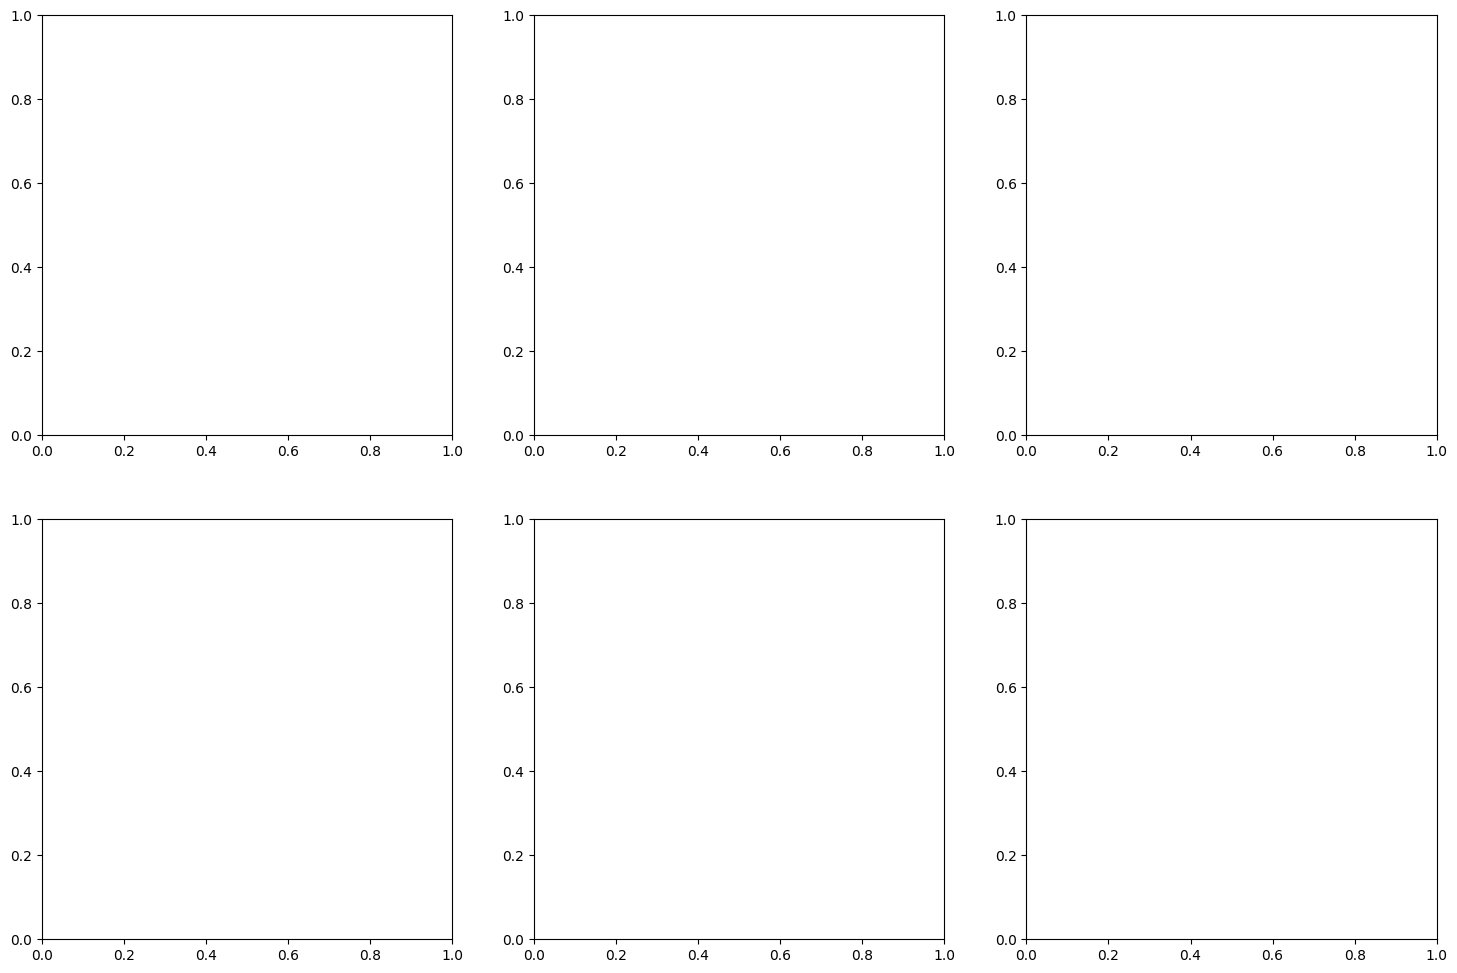

In [ ]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Metrics vs Threshold
ax1 = axes[0, 0]
ax1.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
ax1.plot(thresholds, recall[:-1], label='Recall (Sensitivity)', linewidth=2)
ax1.plot(thresholds, f1_scores[:-1], label='F1-Score', linewidth=2)

# Mark important thresholds
ax1.axvline(x=optimal_f1_threshold, color='red', linestyle='--', alpha=0.7, label='Optimal F1')
ax1.axvline(x=high_sensitivity_threshold, color='green', linestyle='--', alpha=0.7, label='High Sensitivity')
ax1.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Default')

ax1.set_xlabel('Decision Threshold')
ax1.set_ylabel('Score')
ax1.set_title('SVM: Metrics vs Decision Threshold', fontsize=12, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1)

# 2. ROC Curve
ax2 = axes[0, 1]
ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'SVM ROC (AUC={roc_auc_score(y_test, y_proba_svm_best):.3f})')
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)

# Mark threshold points
for name, result in threshold_results_svm.items():
    if name in ['Default (0.5)', 'High Sensitivity', 'Optimal F1']:
        fpr_point = 1 - result['specificity']
        tpr_point = result['sensitivity']
        ax2.scatter(fpr_point, tpr_point, s=100, label=name)

ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('SVM ROC Curve with Key Thresholds', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Precision-Recall Curve
ax3 = axes[0, 2]
ax3.plot(recall, precision, 'g-', linewidth=2)
ax3.scatter(recall[optimal_f1_idx], precision[optimal_f1_idx], 
           color='red', s=100, zorder=5, label=f'Optimal F1 (th={optimal_f1_threshold:.3f})')
ax3.set_xlabel('Recall (Sensitivity)')
ax3.set_ylabel('Precision')
ax3.set_title('SVM Precision-Recall Curve', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrices for Key Thresholds
for idx, (name, threshold) in enumerate([('Default (0.5)', 0.5), 
                                         ('High Sensitivity', high_sensitivity_threshold),
                                         ('Optimal F1', optimal_f1_threshold)]):
    ax = axes[1, idx]
    result = threshold_results_svm[name]
    
    cm = np.array([[result['tn'], result['fp']], 
                   [result['fn'], result['tp']]])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=['No Complication', 'Complication'],
                yticklabels=['No Complication', 'Complication'])
    ax.set_title(f'Confusion Matrix: {name}\nSensitivity={result["sensitivity"]:.1%}, '
                 f'Specificity={result["specificity"]:.1%}', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# Create pipeline with SMOTE
smote_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# Train the model
print("Training Logistic Regression with SMOTE...")
smote_pipeline.fit(X_train, y_train)

# Get predictions
y_pred_smote = smote_pipeline.predict(X_test)
y_proba_smote = smote_pipeline.predict_proba(X_test)[:, 1]

# Initial performance with default threshold
print("\n" + "="*60)
print("LOGISTIC REGRESSION WITH SMOTE (Default Threshold = 0.5)")
print("="*60)
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba_smote):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smote))

# Compare with original (without SMOTE)
print("\n" + "="*60)
print("COMPARISON: With vs Without SMOTE")
print("="*60)
print("Without SMOTE: ROC-AUC = 0.793, Sensitivity = 86%")
print(f"With SMOTE: ROC-AUC = {roc_auc_score(y_test, y_proba_smote):.3f}, "
      f"Sensitivity = {classification_report(y_test, y_pred_smote, output_dict=True)['1']['recall']:.1%}")



Training Logistic Regression with SMOTE...

LOGISTIC REGRESSION WITH SMOTE (Default Threshold = 0.5)
ROC-AUC Score: 0.804

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79        62
           1       0.22      0.86      0.35         7

    accuracy                           0.68        69
   macro avg       0.60      0.76      0.57        69
weighted avg       0.90      0.68      0.74        69


COMPARISON: With vs Without SMOTE
Without SMOTE: ROC-AUC = 0.793, Sensitivity = 86%
With SMOTE: ROC-AUC = 0.804, Sensitivity = 85.7%


In [ ]:
pd.set_option('display.max_columns', None)

# 2) Show all rows
pd.set_option('display.max_rows', 20)

# 3) Print the entire DataFrame
import pandas as pd

# 1) Show all columns
pd.set_option('display.max_columns', None)

# 2) Show all rows
pd.set_option('display.max_rows', None)

# 3) Print the entire DataFrame
print(X_train.to_string(index=True))





     age  height  weight    bmi  family_hist_cnt  chronic_meds_cnt  cholecystectomy_repair  hiatus_hernia_repair  CM_AIDS  CM_ANEMDEF  CM_ARTH  CM_CHF  CM_DEPRESS  CM_DM  CM_DMCX  CM_HTN_C  CM_HYPOTHY  CM_LIVER  CM_OBESE  CM_PSYCH  CM_SMOKE  CM_APNEA  CM_CHOLSTRL  CM_OSTARTH  CM_HPLD  gender_Male  procedure_category_BPD -DS  procedure_category_Mini gastric bypass (OAGB)  procedure_category_RYGBP  procedure_category_SADI  procedure_category_Sleeve  antibiotics_Augmentin  antibiotics_Clindamycin  antibiotics_Invanz  antibiotics_Kefsol  antibiotics_Rocephin
240   33     164   179.0  66.55                0                 0                     0.0                   1.0        0           0        0       0           0      0        0         0           0         0         0         0         0         0            0           0        0        False                       False                                          False                     False                    False                

antibiotics_Augmentin: 179 zeros out of 275 rows
antibiotics_Clindamycin: 263 zeros out of 275 rows
antibiotics_Invanz: 274 zeros out of 275 rows
antibiotics_Kefsol: 112 zeros out of 275 rows
antibiotics_Rocephin: 274 zeros out of 275 rows

Rows where ALL antibiotic dummies are 0 (i.e. original 0): 2



THRESHOLD OPTIMIZATION RESULTS:
Default threshold: 0.500
Optimal F1 threshold: 0.709
High sensitivity (90%) threshold: 0.002
F1 at optimal: 0.571


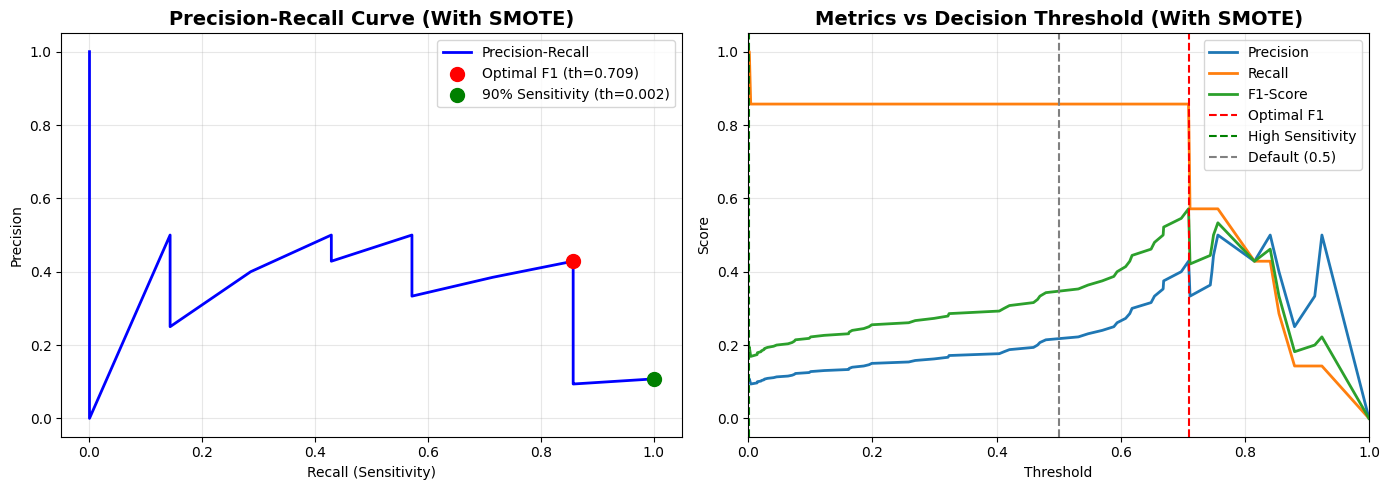

In [ ]:
# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_smote)

# Find optimal threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Find threshold for 90% sensitivity
target_sensitivity = 0.90
sensitivity_idx = np.where(recall >= target_sensitivity)[0][-1] if np.any(recall >= target_sensitivity) else 0
high_sensitivity_threshold = thresholds[sensitivity_idx] if sensitivity_idx < len(thresholds) else 0.3

print(f"\nTHRESHOLD OPTIMIZATION RESULTS:")
print(f"Default threshold: 0.500")
print(f"Optimal F1 threshold: {optimal_threshold:.3f}")
print(f"High sensitivity (90%) threshold: {high_sensitivity_threshold:.3f}")
print(f"F1 at optimal: {f1_scores[optimal_idx]:.3f}")

# Plot threshold analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Precision-Recall curve
ax1.plot(recall, precision, 'b-', label='Precision-Recall', linewidth=2)
ax1.scatter(recall[optimal_idx], precision[optimal_idx], 
           color='red', s=100, zorder=5, label=f'Optimal F1 (th={optimal_threshold:.3f})')

# Add high sensitivity point
if sensitivity_idx < len(recall) - 1:
    ax1.scatter(recall[sensitivity_idx], precision[sensitivity_idx], 
               color='green', s=100, zorder=5, label=f'90% Sensitivity (th={high_sensitivity_threshold:.3f})')

ax1.set_xlabel('Recall (Sensitivity)')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve (With SMOTE)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Threshold vs Metrics
ax2.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
ax2.plot(thresholds, recall[:-1], label='Recall', linewidth=2)
ax2.plot(thresholds, f1_scores[:-1], label='F1-Score', linewidth=2)
ax2.axvline(x=optimal_threshold, color='red', linestyle='--', label='Optimal F1')
ax2.axvline(x=high_sensitivity_threshold, color='green', linestyle='--', label='High Sensitivity')
ax2.axvline(x=0.5, color='gray', linestyle='--', label='Default (0.5)')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Metrics vs Decision Threshold (With SMOTE)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
# Test multiple thresholds
thresholds_to_test = {
    'Default (0.5)': 0.5,
    'Optimal F1': optimal_threshold,
    'High Sensitivity': high_sensitivity_threshold,
    'Custom (0.3)': 0.3,
    'Custom (0.4)': 0.4
}

print("\n" + "="*80)
print("PERFORMANCE AT DIFFERENT THRESHOLDS (With SMOTE)")
print("="*80)
print(f"{'Threshold':<20} {'Sensitivity':<12} {'Specificity':<12} {'Precision':<12} {'F1':<8} {'Complications'}")
print("-"*80)

for name, threshold in thresholds_to_test.items():
    y_pred_threshold = (y_proba_smote >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_threshold)
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    
    print(f"{name:<20} {sensitivity:<12.1%} {specificity:<12.1%} {precision:<12.1%} "
          f"{f1:<8.3f} {tp}/{tp+fn}")

# Apply the optimal threshold based on your needs
chosen_threshold = optimal_threshold  # or high_sensitivity_threshold

y_pred_optimal = (y_proba_smote >= chosen_threshold).astype(int)
print(f"\n{'='*60}")
print(f"FINAL PERFORMANCE WITH CHOSEN THRESHOLD ({chosen_threshold:.3f})")
print(f"{'='*60}")
print(classification_report(y_test, y_pred_optimal))


PERFORMANCE AT DIFFERENT THRESHOLDS (With SMOTE)
Threshold            Sensitivity  Specificity  Precision    F1       Complications
--------------------------------------------------------------------------------
Default (0.5)        85.7%        66.1%        22.2%        0.353    6/7
Optimal F1           85.7%        87.1%        42.9%        0.571    6/7
High Sensitivity     100.0%       6.5%         10.8%        0.194    7/7
Custom (0.3)         85.7%        51.6%        16.7%        0.279    6/7
Custom (0.4)         85.7%        54.8%        17.6%        0.293    6/7

FINAL PERFORMANCE WITH CHOSEN THRESHOLD (0.709)
              precision    recall  f1-score   support

           0       0.98      0.87      0.92        62
           1       0.43      0.86      0.57         7

    accuracy                           0.87        69
   macro avg       0.71      0.86      0.75        69
weighted avg       0.93      0.87      0.89        69



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGB accuracy: 0.8836363636363636
